In [1]:
# import modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle
import datetime
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import math
import nltk
from collections import Counter
import os
import shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
tqdm.pandas()
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
import csv
from scipy import sparse
from sklearn.impute import SimpleImputer

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

2021-07-27 12:35:01.961515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-27 12:35:01.961553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv('mercari/train1.csv')

In [3]:
data.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,len_name,len_item_description,name_desc,name_brand_cat,brand_value,pos,neg,neu
0,0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,unk_brand,10.0,1,unk_desc,Men,Tops,T-shirts,7,1,mlb cincinnati reds t shirt size xl unk_desc,name_mlb cincinnati reds t shirt size xl brand...,0,0.000,0.0,1.000
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,4,18,razer blackwidow chroma keyboard keyboard grea...,name_razer blackwidow chroma keyboard brandraz...,1,0.419,0.0,0.581


In [4]:
data.drop(columns=['train_id', 'name', 'item_description'],inplace=True)

In [5]:
X = data
y = data.price

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
y_train = np.log1p(y_train).values.reshape(-1,1)
y_test  = np.log1p(y_test).values.reshape(-1,1)

In [8]:
# Normalizing the price
scaler_price = MinMaxScaler()
y_train_scaled = scaler_price.fit_transform(y_train)
y_test_scaled =  scaler_price.transform(y_test)
pickle.dump(scaler_price, open('Deep_learning/deep_learning_scaler/scaler_price.pkl','wb'))

In [9]:
def ordinal_encoder(column_name, file_name, training):
    
    '''
        function to give each category a unique value
    '''
    
    if training:
        # converting the categorical values to integer
        ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1)
        train_ = ordinal_encoder.fit_transform(X_train[column_name].astype(str).values.reshape(-1,1)).reshape(-1,1)
        test_  = ordinal_encoder.transform(X_test[column_name].astype(str).values.reshape(-1,1)).reshape(-1,1)
        categories_len = ordinal_encoder.categories_[0].shape[0]
        
        # for imputation of most_frequent values
        imputer = SimpleImputer(missing_values=-1, strategy='most_frequent')
        train_impute = imputer.fit_transform(train_)
        test_impute  = imputer.transform(test_)


        pickle.dump(ordinal_encoder, open('Deep_learning/encoder/' + file_name + '_ordinal_encoder.pkl', "wb"))
        pickle.dump(imputer,         open('Deep_learning/imputer/' + file_name + '_imputer.pkl','wb'))
        return train_impute, test_impute, categories_len
        
    else:
        ordinal_encoder = pickle.load(open('Deep_learning/encoder/' + file_name + '_ordinal_encoder.pkl', "rb"))
        test_ord        = ordinal_encoder.transform(test_df[column_name].astype(str).values.reshape(-1,1)).reshape(-1,1)
        imputer         = pickle.load(open('Deep_learning/imputer/' + file_name + '_imputer.pkl','rb'))
        test_impute     = imputer.transform(test_ord)
        
        return test_impute
        
   

In [10]:
train_item_condition_id, test_item_condition_id, item_condition_id_len = ordinal_encoder('item_condition_id', 'item_condition_id', training = True)
train_brand_name, test_brand_name, brand_name_len = ordinal_encoder('brand_name', 'brand_name', training = True)
train_shipping, test_shipping, shipping_len = ordinal_encoder('shipping', 'shipping', training = True)
train_category, test_category, category_len = ordinal_encoder('category_name', 'category_name', training = True)
train_main_category, test_main_category, main_category_len = ordinal_encoder('main_category', 'main_category', training = True)
train_sub_category1, test_sub_category1, sub_category1_len = ordinal_encoder('sub_category1', 'sub_category1', training = True)
train_sub_category2, test_sub_category2, sub_category2_len = ordinal_encoder('sub_category2', 'sub_category2', training = True)

In [11]:
def min_max_scaler(train, test, file_name, training):
    '''
        function to perform scaling of feature columns
    '''
    if training:
        scaler = MinMaxScaler()
        train_scaler = scaler.fit_transform(train)
        test_scaler  = scaler.transform(test)
        pickle.dump(scaler, open('Deep_learning/deep_learning_scaler/' + file_name +'.pkl', "wb"))
        return train_scaler, test_scaler
    
    else:
        scaler = pickle.load(open('Deep_learning/deep_learning_scaler/' + file_name +'.pkl', "rb"))
        test_scaler = scaler.transform(test)
        
        return test_scaler

In [12]:
train_item_condition_id, test_item_condition_id = min_max_scaler(train_item_condition_id, test_item_condition_id,'item_condition_id_scaler', training = True)
train_brand_name, test_brand_name = min_max_scaler(train_brand_name, test_brand_name, 'brand_scaler', training = True)
train_category, test_category  = min_max_scaler(train_category, test_category, 'category_scaler', training = True)
train_main_category, test_main_category = min_max_scaler(train_main_category, test_main_category, 'main_category_scaler', training = True)
train_sub_category1, test_sub_category1 = min_max_scaler(train_sub_category1, test_sub_category1, 'sub_category1_scaler', training = True)
train_sub_category2, test_sub_category2 = min_max_scaler(train_sub_category2, test_sub_category2, 'sub_category2_scaler', training = True)
train_len_name, test_len_name = min_max_scaler(X_train['len_name'].values.reshape(-1,1), X_test['len_name'].values.reshape(-1,1), 'len_name_scaler', training = True)
train_len_item_desc, test_len_item_desc = min_max_scaler(X_train['len_item_description'].values.reshape(-1,1), X_test['len_item_description'].values.reshape(-1,1), 'len_item_desc_scaler', training = True)


In [13]:
def text_to_sequences(train, test, file_name, training):
    '''
        function to perform text tokenizer 
        returns train_tokenizer and test_tokenizer
    '''
    
    if training:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(train.astype(str))
        train_text = tokenizer.texts_to_sequences(train.astype(str))
        test_text  = tokenizer.texts_to_sequences(test.astype(str))
        pickle.dump(tokenizer, open('Deep_learning/tokenizer/' + file_name + '.pkl', 'wb'))
    
        return train_text, test_text, tokenizer
    else:
        tokenizer = pickle.load(open('Deep_learning/tokenizer/' + file_name + '.pkl', 'rb'))
        test_text = tokenizer.texts_to_sequences(test)
        return test_text

In [14]:
def text_padding(train, test, length, training):
    '''
        function to perform post-padding of sequences
        returns padding_train, padding_test
    '''
    
    if training:
        train = pad_sequences(train, maxlen=length, padding='post')
        test  = pad_sequences(test,  maxlen=length, padding='post')

        return train, test
    
    else:
        test_ = pad_sequences(test,  maxlen=length, padding='post')
        
        return test_

In [15]:
# converting the text features to their respective tokens form
train_name_desc, test_name_desc, name_desc_tokenizer = text_to_sequences(X_train['name_desc'], X_test['name_desc'], 'name_desc_tokenizer', training = True)
train_name_brand_cat, test_name_brand_cat, name_brand_cat_tokenizer = text_to_sequences(X_train['name_brand_cat'], X_test['name_brand_cat'], 'name_brand_cat_tokenizer', training=True)


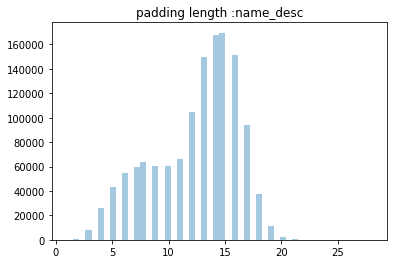

In [16]:
text_len = [len(x) for x in train_name_desc]
sns.distplot(text_len, kde=False).set_title("padding length :"+ str('name_desc'))
plt.show()

In [17]:
# looking at the bar graph setting the thresold to be 20
# checking what percentage of sentences are above 20 length
len(list(filter(lambda x: x > 20, text_len))) / len(text_len)

0.0005736808714549897

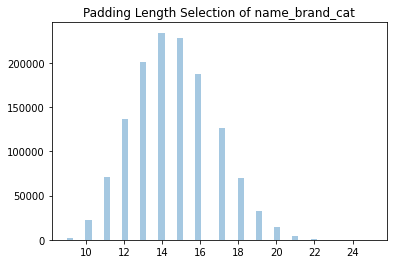

In [24]:
text_len = [len(x) for x in train_name_brand_cat]
sns.distplot(text_len, kde=False).set_title("padding length :"+ str('name_brand_cat'))
plt.show()

In [18]:
# looking at the bar graph setting the thresold to be 21
# checking what percentage of sentences are above 21 length
len(list(filter(lambda x: x > 21, text_len))) / len(text_len)

0.00015073183681366397

In [19]:
# setting the thresold
name_desc_len = 20
name_brand_cat_len = 21

# padding the text features
train_name_desc, test_name_desc = text_padding(train_name_desc, test_name_desc, name_desc_len, training=True)
train_name_brand_cat, test_name_brand_cat = text_padding(train_name_brand_cat, test_name_brand_cat, name_brand_cat_len, training=True)

In [20]:
X_train.drop(columns=['brand_name','category_name', 'main_category', 'sub_category1', 'sub_category2'], inplace=True)
X_test.drop(columns=['brand_name','category_name', 'main_category', 'sub_category1', 'sub_category2'], inplace=True)

In [21]:
# loading the glove vector
# embedding dictionary for key value pairs :- where keys are words and values are its vector representation
embedding_dict = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()


In [22]:
def create_embedding_matrix(tokenizer):
    
    '''
        this function creates a embedding vector for the embedding_layer
    '''
    
    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [23]:
name_desc_embedding = create_embedding_matrix(name_desc_tokenizer)
name_brand_cat_embedding = create_embedding_matrix(name_brand_cat_tokenizer)

In [24]:
vocab_size_name_desc = len(name_desc_tokenizer.word_index) + 1
vocab_size_name_brand_cat = len(name_brand_cat_tokenizer.word_index) + 1

In [25]:
# creating embedding layer for name_desc feature
embedding_layer_name_desc = layers.Embedding(
    vocab_size_name_desc,
    100,
    embeddings_initializer=keras.initializers.Constant(name_desc_embedding),
    trainable=False,
)


In [26]:
# creating embedding layer for name_brand_cat
embedding_layer_name_brand_cat = layers.Embedding(
    vocab_size_name_brand_cat,
    100,
    embeddings_initializer=keras.initializers.Constant(vocab_size_name_brand_cat),
    trainable=False,
)


In [27]:
def make_model():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************    
    input_name_desc = keras.Input(shape=(20, ), name="name_desc_input")
    embedded_name_desc = embedding_layer_name_desc(input_name_desc)
    lstm_name_desc = layers.LSTM(100,kernel_initializer = 'glorot_uniform', return_sequences=True)(embedded_name_desc)
    flatten_name_desc = layers.Flatten()(lstm_name_desc)
    
    input_name_brand_cat = keras.Input(shape=(21, ), name="name_brand_cat_input")
    embedded_name_brand_cat = embedding_layer_name_brand_cat(input_name_brand_cat)
    lstm_name_brand_cat = layers.LSTM(100,kernel_initializer = 'glorot_uniform', return_sequences=True)(embedded_name_brand_cat)
    flatten_brand_cat = layers.Flatten()(lstm_name_brand_cat)
    
    
    # ****************************************categorical embeddings************************************************
    
    
    input_item_condition_id = keras.Input(shape=1, name='item_condition_id' + '_input')
    embd_layer_item_condition_id = layers.Embedding(input_dim=item_condition_id_len+1, output_dim = 32, trainable = True, name='item_condition_id'+'_embedding_layer')(input_item_condition_id)
    flatten_item_condition_id = layers.Flatten()(embd_layer_item_condition_id)
    
    input_category_name = keras.Input(shape=1, name='category_name' + '_input')
    embd_layer_category_name = layers.Embedding(input_dim=category_len + 1, output_dim = 32, trainable = True, name='category_name'+'_embedding_layer')(input_category_name)
    flatten_category_name = layers.Flatten()(embd_layer_category_name)
    
    input_brand_name = keras.Input(shape=1, name='brand_name' + '_input')
    embd_layer_brand_name = layers.Embedding(input_dim=brand_name_len + 1, output_dim = 32, trainable = True, name='brand_name'+'_embedding_layer')(input_brand_name)
    flatten_brand_name = layers.Flatten()(embd_layer_brand_name)
    
    input_shipping = keras.Input(shape=1, name='shipping' + '_input')
    embd_layer_shipping = layers.Embedding(input_dim=shipping_len + 1, output_dim = 32, trainable = True, name='shipping'+'_embedding_layer')(input_shipping)
    flatten_shipping = layers.Flatten()(embd_layer_shipping)
    
    input_main_category = keras.Input(shape=1, name='main_category' + '_input')
    embd_layer_main_category = layers.Embedding(input_dim=main_category_len + 1, output_dim = 32, trainable = True, name='main_category'+'_embedding_layer')(input_main_category)
    flatten_main_category = layers.Flatten()(embd_layer_main_category)
    
    input_sub_category1 = keras.Input(shape=1, name='sub_category1' + '_input')
    embd_layer_sub_category1 = layers.Embedding(input_dim=sub_category1_len + 1, output_dim = 32, trainable = True, name='sub_category1'+'_embedding_layer')(input_sub_category1)
    flatten_sub_category1 = layers.Flatten()(embd_layer_sub_category1)
    
    input_sub_category2 = keras.Input(shape=1, name='sub_category2' + '_input')
    embd_layer_sub_category2 = layers.Embedding(input_dim=sub_category2_len + 1, output_dim = 32, trainable = True, name='sub_category2'+'_embedding_layer')(input_sub_category2)
    flatten_sub_category2 = layers.Flatten()(embd_layer_sub_category2)
    
    
    
    # ***************************************numerical features*****************************************************
    input_other_than_text = keras.Input(shape=(5,), name='numerical_feature')
    dense_numerical_feature = layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.he_normal(),\
                                           kernel_regularizer=keras.regularizers.l2(0.0001))(input_other_than_text)
    
    
    #***************************************concatenating layers****************************************************
#     layers_list = 

    layer_ = layers.Concatenate()([flatten_name_desc, flatten_brand_cat, flatten_item_condition_id, flatten_category_name, \
                                      flatten_brand_name, flatten_shipping, flatten_main_category, flatten_sub_category1, \
                                       flatten_sub_category2, dense_numerical_feature])
    
    
    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=128, activation='relu')(layer_)
    
    output = layers.Dense(1, activation='linear', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_name_desc, input_name_brand_cat, input_item_condition_id, input_category_name, \
                                input_brand_name, input_shipping, input_main_category, input_sub_category1, \
                                input_sub_category2, input_other_than_text], \
                        outputs = output
                        )
    
    return model
       

In [28]:
model = make_model()
model.summary()

2021-07-27 12:37:32.173506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-27 12:37:32.173555: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-27 12:37:32.173589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-3): /proc/driver/nvidia/version does not exist
2021-07-27 12:37:32.173858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_desc_input (InputLayer)    [(None, 20)]         0                                            
__________________________________________________________________________________________________
name_brand_cat_input (InputLaye [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      14264700    name_desc_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 100)      10373900    name_brand_cat_input[0][0]       
______________________________________________________________________________________________

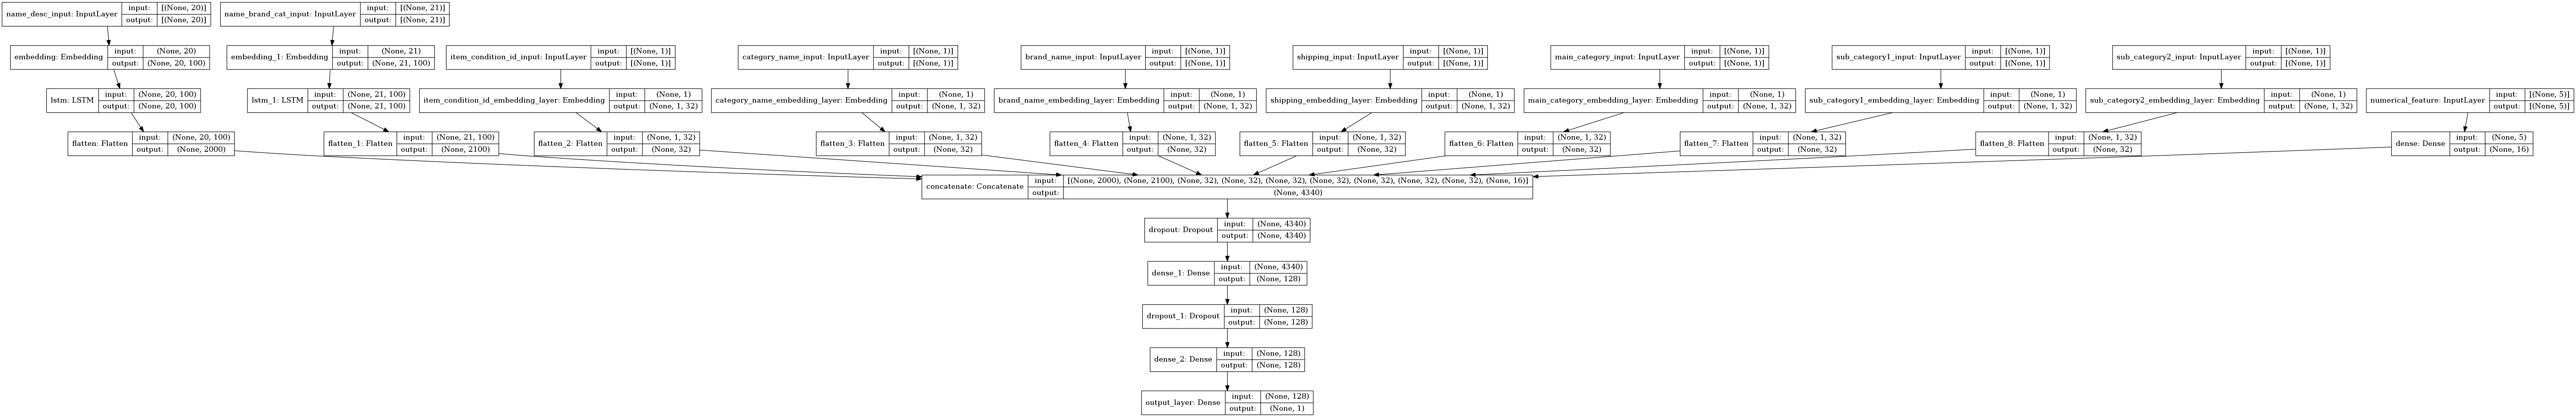

In [29]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=96)

In [30]:
# stacking the numerical features horizontally

X_train_hstack = np.hstack((train_len_name, train_len_item_desc, X_train['pos'].values.reshape(-1,1), X_train['neg'].values.reshape(-1,1), \
                        X_train['neu'].values.reshape(-1,1)))


X_test_hstack = np.hstack((test_len_name, test_len_item_desc, X_test['pos'].values.reshape(-1,1), X_test['neg'].values.reshape(-1,1),\
                        X_test['neu'].values.reshape(-1,1)))

In [31]:
X_train = [train_name_desc, train_name_brand_cat, train_item_condition_id, train_category, train_brand_name, train_shipping, \
              train_main_category, train_sub_category1, train_sub_category2, X_train_hstack] 

X_test  = [test_name_desc, test_name_brand_cat, test_item_condition_id, test_category, test_brand_name, test_shipping, \
              test_main_category, test_sub_category1, test_sub_category2, X_test_hstack]

In [60]:

model_path = "checkpoint/model.hdfs"
checking_point = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

lrscheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

model.compile(optimizer=Adam(0.0003), loss='mse', metrics=[RootMeanSquaredError()])

model_history = model.fit(x=X_train, y=y_train_scaled, batch_size=1024, epochs=50, verbose=True, validation_data=(X_test, y_test_scaled), 
                           callbacks=[checking_point])

2021-07-27 06:41:52.070903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-27 06:41:52.071708: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200155000 Hz


Epoch 1/50
1303/1303 [==============================] - 248s 187ms/step - loss: 0.0144 - root_mean_squared_error: 0.1118 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1096

Epoch 00001: val_loss improved from inf to 0.01313, saving model to checkpoint/model.hdfs


2021-07-27 06:46:21.789781: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 2/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0094 - root_mean_squared_error: 0.0932 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1025

Epoch 00002: val_loss improved from 0.01313 to 0.01085, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 3/50
1303/1303 [==============================] - 244s 188ms/step - loss: 0.0083 - root_mean_squared_error: 0.0903 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1059

Epoch 00003: val_loss did not improve from 0.01085
Epoch 4/50
1303/1303 [==============================] - 241s 185ms/step - loss: 0.0079 - root_mean_squared_error: 0.0885 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047

Epoch 00004: val_loss did not improve from 0.01085
Epoch 5/50
1303/1303 [==============================] - 241s 185ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991

Epoch 00005: val_loss improved from 0.01085 to 0.00982, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 6/50
1303/1303 [==============================] - 242s 186ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991

Epoch 00006: val_loss did not improve from 0.00982
Epoch 7/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947

Epoch 00007: val_loss improved from 0.00982 to 0.00897, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 8/50
1303/1303 [==============================] - 243s 186ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014

Epoch 00008: val_loss did not improve from 0.00897
Epoch 9/50
1303/1303 [==============================] - 242s 186ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009

Epoch 00009: val_loss did not improve from 0.00897
Epoch 10/50
1303/1303 [==============================] - 240s 185ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011

Epoch 00010: val_loss did not improve from 0.00897
Epoch 11/50
1303/1303 [==============================] - 242s 186ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0972

Epoch 00011: val_loss did not improve from 0.00897
Epoch 12/50
1303/1303 [==============================] - 242s 186ms/step - los

INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 14/50
1303/1303 [==============================] - 243s 187ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975

Epoch 00014: val_loss did not improve from 0.00891
Epoch 15/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958

Epoch 00015: val_loss did not improve from 0.00891
Epoch 16/50
1303/1303 [==============================] - 245s 188ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926

Epoch 00016: val_loss improved from 0.00891 to 0.00857, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 17/50
1303/1303 [==============================] - 243s 187ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016

Epoch 00017: val_loss did not improve from 0.00857
Epoch 18/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960

Epoch 00018: val_loss did not improve from 0.00857
Epoch 19/50
1303/1303 [==============================] - 242s 186ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963

Epoch 00019: val_loss did not improve from 0.00857
Epoch 20/50
1303/1303 [==============================] - 241s 185ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930

Epoch 00020: val_loss did not improve from 0.00857
Epoch 21/50
1303/1303 [==============================] - 241s 185ms/step - l

INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 34/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935

Epoch 00034: val_loss did not improve from 0.00812
Epoch 35/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969

Epoch 00035: val_loss did not improve from 0.00812
Epoch 36/50
1303/1303 [==============================] - 247s 189ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927

Epoch 00036: val_loss did not improve from 0.00812
Epoch 37/50
1303/1303 [==============================] - 245s 188ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898

Epoch 00037: val_loss improved from 0.00812 to 0.00806, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 38/50
1303/1303 [==============================] - 247s 189ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932

Epoch 00040: val_loss did not improve from 0.00806
Epoch 41/50
1303/1303 [==============================] - 246s 189ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912

Epoch 00041: val_loss did not improve from 0.00806
Epoch 42/50
1303/1303 [==============================] - 245s 188ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931

Epoch 00042: val_loss did not improve from 0.00806
Epoch 43/50
1303/1303 [==============================] - 246s 189ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886

Epoch 00043: val_loss improved from 0.00806 to 0.00785, saving model to checkpoint/model.hdfs


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model.hdfs/assets


Epoch 44/50
1303/1303 [==============================] - 248s 190ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923

Epoch 00044: val_loss did not improve from 0.00785
Epoch 45/50
1303/1303 [==============================] - 248s 190ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912

Epoch 00045: val_loss did not improve from 0.00785
Epoch 46/50
1303/1303 [==============================] - 246s 189ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901

Epoch 00046: val_loss did not improve from 0.00785
Epoch 47/50
1303/1303 [==============================] - 244s 187ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905

Epoch 00047: val_loss did not improve from 0.00785
Epoch 48/50
1303/1303 [==============================] - 245s 188ms/step - l

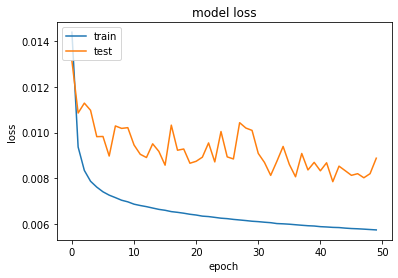

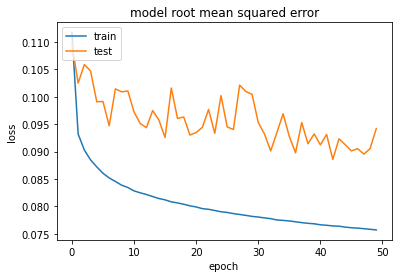

In [69]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['root_mean_squared_error'])
plt.plot(model_history.history['val_root_mean_squared_error'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission 

In [51]:
test_df = pd.read_csv('mercari/test2_feature_engineering.csv')
test_df.head(2)

,Unnamed: 0,Unnamed: 0.1,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,sub_category1,sub_category2,len_name,len_item_description,name_desc,name_brand_cat,brand_value,pos,neg,neu
0,0,0,0,breast cancer i fight like a girl ring,1,Women/Jewelry/Rings,unk_brand,1,size 7,Women,Jewelry,Rings,8,2,breast cancer i fight like a girl ring size 7,name_breast cancer i fight like a girl ring br...,0,0.000,0.0,1.000
1,1,1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,unk_brand,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,9,33,25 pcs new 7 5 x12 kraft bubble mailers 25 pcs...,name_25 pcs new 7 5 x12 kraft bubble mailers b...,0,0.289,0.0,0.711


In [52]:
test_df.shape

(3460725, 20)

In [53]:
X_test_item_condition_id   = ordinal_encoder('item_condition_id', 'item_condition_id', training = False)
X_test_brand_name          = ordinal_encoder('brand_name', 'brand_name', training = False)
X_test_shipping            = ordinal_encoder('shipping', 'shipping', training = False)
X_test_category            = ordinal_encoder('category_name', 'category_name', training = False)
X_test_main_category       = ordinal_encoder('main_category', 'main_category', training = False)
X_test_sub_category1       = ordinal_encoder('sub_category1', 'sub_category1', training = False)
X_test_sub_category2       = ordinal_encoder('sub_category2', 'sub_category2', training = False)

In [54]:
X_test_item_condition_id = min_max_scaler(_, X_test_item_condition_id,'item_condition_id_scaler', training = False)
X_test_brand_name        = min_max_scaler(_, X_test_brand_name, 'brand_scaler', training = False)
X_test_category          = min_max_scaler(_, X_test_category, 'category_scaler', training = False)
X_test_main_category     = min_max_scaler(_, X_test_main_category, 'main_category_scaler', training = False)
X_test_sub_category1     = min_max_scaler(_, X_test_sub_category1, 'sub_category1_scaler', training = False)
X_test_sub_category2     = min_max_scaler(_, X_test_sub_category2, 'sub_category2_scaler', training = False)
X_test_len_name          = min_max_scaler(_, test_df['len_name'].values.reshape(-1,1), 'len_name_scaler', training = False)
X_test_len_item_desc     = min_max_scaler(_, test_df['len_item_description'].values.reshape(-1,1), 'len_item_desc_scaler', training = False)


In [55]:
X_test_name_desc      = text_to_sequences(_, test_df['name_desc'], 'name_desc_tokenizer', training = False)
X_test_name_brand_cat = text_to_sequences(_, test_df['name_brand_cat'], 'name_brand_cat_tokenizer', training=False)


In [56]:
name_desc_len = 20
name_brand_cat_len = 21

X_test_name_desc      = text_padding(_, X_test_name_desc, name_desc_len, training=False)
X_test_name_brand_cat = text_padding(_, X_test_name_brand_cat, name_brand_cat_len, training=False)

In [57]:
test_hstack = np.hstack((X_test_len_name, X_test_len_item_desc, test_df['pos'].values.reshape(-1,1), test_df['neg'].values.reshape(-1,1),\
                        test_df['neu'].values.reshape(-1,1)))

In [58]:
test_input  = [X_test_name_desc, X_test_name_brand_cat, X_test_item_condition_id, X_test_category, X_test_brand_name, X_test_shipping, \
              X_test_main_category, X_test_sub_category1, X_ test_sub_category2, test_hstack]

In [50]:
# loading the model weights
path = "checkpoint/model.hdfs"
model_ = keras.models.load_model(path)

In [51]:
# predicting the prices
predicted_price = model_.predict(test_input)

In [52]:
# loading the pickle file
price_scaler = pickle.load(open('Deep_learning/deep_learning_scaler/scaler_price.pkl','rb'))
# getting the original price
predicted_price = np.expm1(price_scaler.inverse_transform(predicted_price.reshape(-1,1)))

In [55]:
submission_df          = pd.DataFrame(test_df.test_id, columns=['test_id'])
submission_df['price'] = predicted_price

In [56]:
submission_df.to_csv('submission/deep_learning_submission.csv')

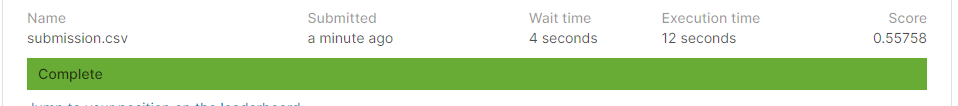

In [52]:
from IPython.display import Image
Image(filename='models_score/deep_learning.png') 

## Model with CNN

In [32]:
def model_cnn():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************  
    # CNN with LSTM
    #https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd
    
    input_name_desc = keras.Input(shape=(20, ), name="name_desc_input")
    embedded_name_desc = embedding_layer_name_desc(input_name_desc)
    conv_1d_name_desc = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_name_desc)
    max_pool_name_desc = MaxPooling1D(pool_size=2)(conv_1d_name_desc)
#     lstm_name_desc = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_name_desc)
    flatten_name_desc = layers.Flatten()(max_pool_name_desc)
    
    input_name_brand_cat = keras.Input(shape=(21, ), name="name_brand_cat_input")
    embedded_name_brand_cat = embedding_layer_name_brand_cat(input_name_brand_cat)
    conv_1d_brand_cat = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_name_brand_cat)
    max_pool_brand_cat = MaxPooling1D(pool_size=2)(conv_1d_brand_cat)
#     lstm_name_brand_cat = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_brand_cat)
    flatten_brand_cat = layers.Flatten()(max_pool_brand_cat)
    
    
    # ****************************************categorical embeddings************************************************
    
    
    input_item_condition_id = keras.Input(shape=1, name='item_condition_id' + '_input')
    embd_layer_item_condition_id = layers.Embedding(input_dim=item_condition_id_len+1, output_dim = 32, trainable = True, name='item_condition_id'+'_embedding_layer')(input_item_condition_id)
    flatten_item_condition_id = layers.Flatten()(embd_layer_item_condition_id)
    
    input_category_name = keras.Input(shape=1, name='category_name' + '_input')
    embd_layer_category_name = layers.Embedding(input_dim=category_len + 1, output_dim = 32, trainable = True, name='category_name'+'_embedding_layer')(input_category_name)
    flatten_category_name = layers.Flatten()(embd_layer_category_name)
    
    input_brand_name = keras.Input(shape=1, name='brand_name' + '_input')
    embd_layer_brand_name = layers.Embedding(input_dim=brand_name_len + 1, output_dim = 32, trainable = True, name='brand_name'+'_embedding_layer')(input_brand_name)
    flatten_brand_name = layers.Flatten()(embd_layer_brand_name)
    
    input_shipping = keras.Input(shape=1, name='shipping' + '_input')
    embd_layer_shipping = layers.Embedding(input_dim=shipping_len + 1, output_dim = 32, trainable = True, name='shipping'+'_embedding_layer')(input_shipping)
    flatten_shipping = layers.Flatten()(embd_layer_shipping)
    
    input_main_category = keras.Input(shape=1, name='main_category' + '_input')
    embd_layer_main_category = layers.Embedding(input_dim=main_category_len + 1, output_dim = 32, trainable = True, name='main_category'+'_embedding_layer')(input_main_category)
    flatten_main_category = layers.Flatten()(embd_layer_main_category)
    
    input_sub_category1 = keras.Input(shape=1, name='sub_category1' + '_input')
    embd_layer_sub_category1 = layers.Embedding(input_dim=sub_category1_len + 1, output_dim = 32, trainable = True, name='sub_category1'+'_embedding_layer')(input_sub_category1)
    flatten_sub_category1 = layers.Flatten()(embd_layer_sub_category1)
    
    input_sub_category2 = keras.Input(shape=1, name='sub_category2' + '_input')
    embd_layer_sub_category2 = layers.Embedding(input_dim=sub_category2_len + 1, output_dim = 32, trainable = True, name='sub_category2'+'_embedding_layer')(input_sub_category2)
    flatten_sub_category2 = layers.Flatten()(embd_layer_sub_category2)
    
    
    
    # ***************************************numerical features*****************************************************
    input_other_than_text = keras.Input(shape=(5,), name='numerical_feature')
    dense_numerical_feature = layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.he_normal(),\
                                           kernel_regularizer=keras.regularizers.l2(0.0001))(input_other_than_text)
    
    
    #***************************************concatenating layers****************************************************
#     layers_list = 

    layer_ = layers.Concatenate()([flatten_name_desc, flatten_brand_cat, flatten_item_condition_id, flatten_category_name, \
                                      flatten_brand_name, flatten_shipping, flatten_main_category, flatten_sub_category1, \
                                       flatten_sub_category2, dense_numerical_feature])
    
    
    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=128, activation='relu')(layer_)
    
    output = layers.Dense(1, activation='linear', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_name_desc, input_name_brand_cat, input_item_condition_id, input_category_name, \
                                input_brand_name, input_shipping, input_main_category, input_sub_category1, \
                                input_sub_category2, input_other_than_text], \
                        outputs = output
                        )
    
    return model
       

In [33]:
model_cnn = model_cnn()
model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_desc_input (InputLayer)    [(None, 20)]         0                                            
__________________________________________________________________________________________________
name_brand_cat_input (InputLaye [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      14264700    name_desc_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 100)      10373900    name_brand_cat_input[0][0]       
____________________________________________________________________________________________

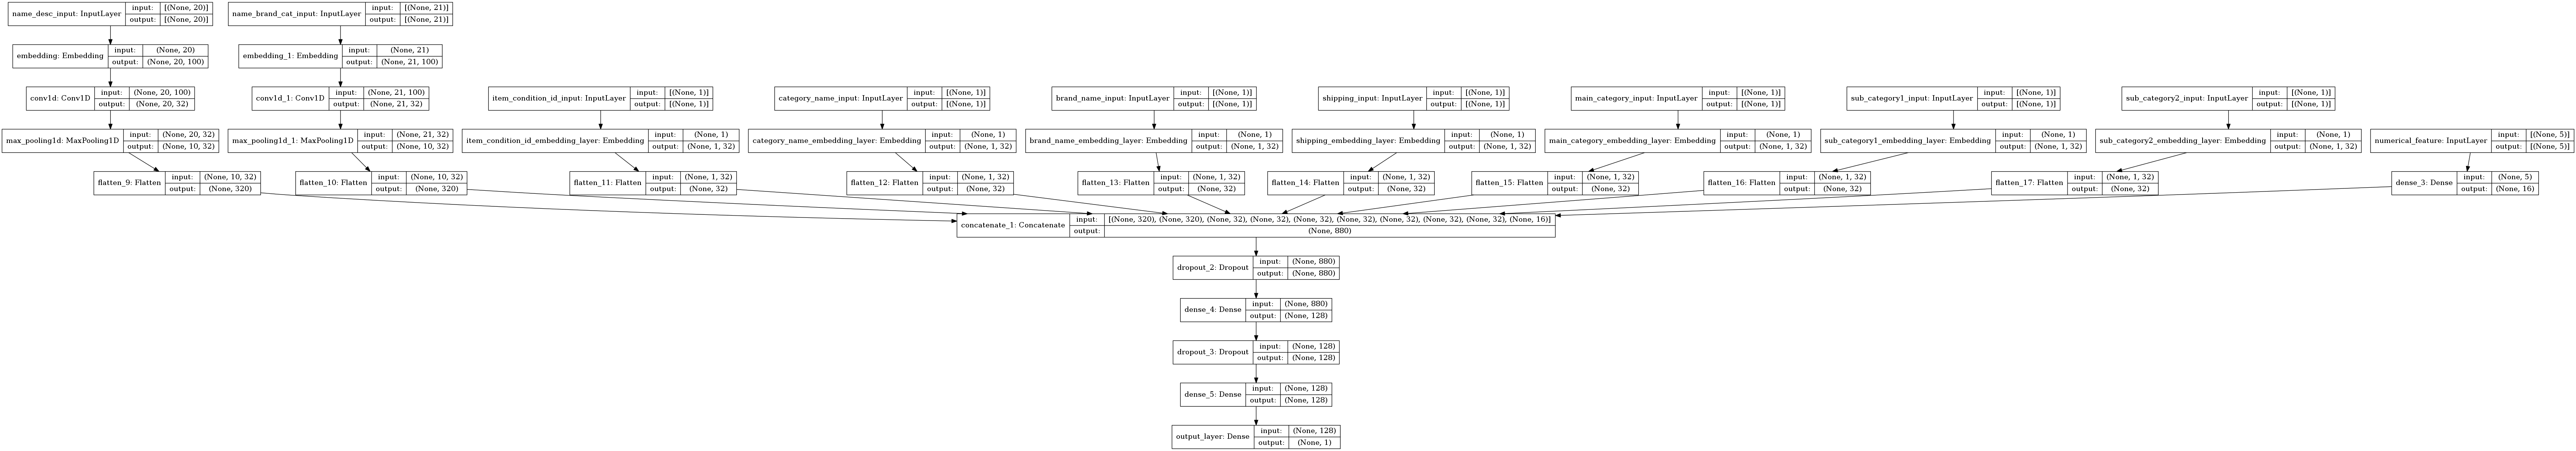

In [34]:
tf.keras.utils.plot_model(model_cnn, to_file='model_cnn.png', show_shapes=True, dpi=96)

In [35]:

model_path = "checkpoint/model_cnn_1.hdfs"
checking_point = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

lrscheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

model_cnn.compile(optimizer=Adam(0.0003), loss='mse', metrics=[RootMeanSquaredError()])

model_cnn_history = model_cnn.fit(x=X_train, y=y_train_scaled, batch_size=1024, epochs=50, verbose=True, validation_data=(X_test, y_test_scaled), 
                           callbacks=[checking_point])

2021-07-27 12:37:35.006415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-27 12:37:35.007565: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200155000 Hz


Epoch 1/50
1303/1303 [==============================] - 42s 31ms/step - loss: 20560056.0000 - root_mean_squared_error: 4534.3198 - val_loss: 270.3701 - val_root_mean_squared_error: 16.4428

Epoch 00001: val_loss improved from inf to 270.37015, saving model to checkpoint/model_cnn_1.hdfs


2021-07-27 12:38:33.897042: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkpoint/model_cnn_1.hdfs/assets
Epoch 2/50
1303/1303 [==============================] - 40s 31ms/step - loss: 36660.3125 - root_mean_squared_error: 191.4688 - val_loss: 68.2275 - val_root_mean_squared_error: 8.2598

Epoch 00002: val_loss improved from 270.37015 to 68.22753, saving model to checkpoint/model_cnn_1.hdfs
INFO:tensorflow:Assets written to: checkpoint/model_cnn_1.hdfs/assets
Epoch 3/50
1303/1303 [==============================] - 40s 31ms/step - loss: 2003.7471 - root_mean_squared_error: 44.7632 - val_loss: 15.5991 - val_root_mean_squared_error: 3.9492

Epoch 00003: val_loss improved from 68.22753 to 15.59909, saving model to checkpoint/model_cnn_1.hdfs
INFO:tensorflow:Assets written to: checkpoint/model_cnn_1.hdfs/assets
Epoch 4/50
1303/1303 [==============================] - 40s 31ms/step - loss: 62.9133 - root_mean_squared_error: 7.9316 - val_loss: 0.6704 - val_root_mean_squared_error: 0.8168

Epoch 00004: val_loss improved from 15.59

1303/1303 [==============================] - 40s 31ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190

Epoch 00026: val_loss did not improve from 0.01136
Epoch 27/50
1303/1303 [==============================] - 40s 31ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151

Epoch 00027: val_loss did not improve from 0.01136
Epoch 28/50
1303/1303 [==============================] - 40s 31ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211

Epoch 00028: val_loss did not improve from 0.01136
Epoch 29/50
1303/1303 [==============================] - 40s 31ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188

Epoch 00029: val_loss did not improve from 0.01136
Epoch 30/50
1303/1303 [==============================] - 40s 31ms/step - loss: 0.0102 - root_mea

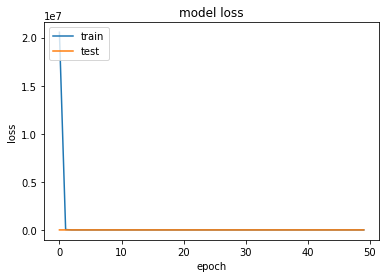

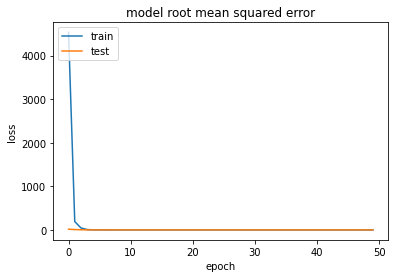

In [36]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_cnn_history.history['loss'])
plt.plot(model_cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_cnn_history.history['root_mean_squared_error'])
plt.plot(model_cnn_history.history['val_root_mean_squared_error'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission with cnn

In [66]:
# loading the model weights
path = "checkpoint/model_cnn_1.hdfs"
model_cnn = keras.models.load_model(path)

In [67]:
# predicting the prices
predicted_price = model_cnn.predict(test_input)

In [68]:
# loading the pickle file
price_scaler = pickle.load(open('Deep_learning/deep_learning_scaler/scaler_price.pkl','rb'))
# getting the original price
predicted_price = np.expm1(price_scaler.inverse_transform(predicted_price.reshape(-1,1)))

In [69]:
submission_df          = pd.DataFrame(test_df.test_id, columns=['test_id'])
submission_df['price'] = predicted_price

In [70]:
submission_df.to_csv('submission/deep_learning_submission_cnn.csv')

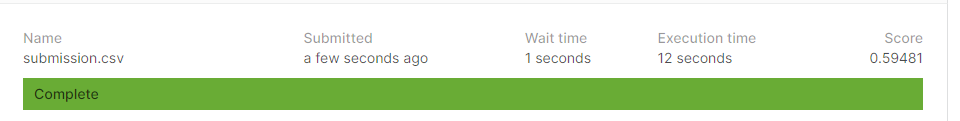

In [51]:
from IPython.display import Image
Image(filename='models_score/deep_cnn.png') 

## CNN with LSTM CNN

In [37]:
def model_lstm_Cnn():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************  
    # CNN with LSTM
    #https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd
    
    input_name_desc = keras.Input(shape=(20, ), name="name_desc_input")
    embedded_name_desc = embedding_layer_name_desc(input_name_desc)
    conv_1d_name_desc = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_name_desc)
    max_pool_name_desc = MaxPooling1D(pool_size=2)(conv_1d_name_desc)
    lstm_name_desc = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_name_desc)
    flatten_name_desc = layers.Flatten()(lstm_name_desc)
    
    input_name_brand_cat = keras.Input(shape=(21, ), name="name_brand_cat_input")
    embedded_name_brand_cat = embedding_layer_name_brand_cat(input_name_brand_cat)
    conv_1d_brand_cat = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_name_brand_cat)
    max_pool_brand_cat = MaxPooling1D(pool_size=2)(conv_1d_brand_cat)
    lstm_name_brand_cat = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_brand_cat)
    flatten_brand_cat = layers.Flatten()(lstm_name_brand_cat)
    
    
    # ****************************************categorical embeddings************************************************
    
    
    input_item_condition_id = keras.Input(shape=1, name='item_condition_id' + '_input')
    embd_layer_item_condition_id = layers.Embedding(input_dim=item_condition_id_len+1, output_dim = 32, trainable = True, name='item_condition_id'+'_embedding_layer')(input_item_condition_id)
    flatten_item_condition_id = layers.Flatten()(embd_layer_item_condition_id)
    
    input_category_name = keras.Input(shape=1, name='category_name' + '_input')
    embd_layer_category_name = layers.Embedding(input_dim=category_len + 1, output_dim = 32, trainable = True, name='category_name'+'_embedding_layer')(input_category_name)
    flatten_category_name = layers.Flatten()(embd_layer_category_name)
    
    input_brand_name = keras.Input(shape=1, name='brand_name' + '_input')
    embd_layer_brand_name = layers.Embedding(input_dim=brand_name_len + 1, output_dim = 32, trainable = True, name='brand_name'+'_embedding_layer')(input_brand_name)
    flatten_brand_name = layers.Flatten()(embd_layer_brand_name)
    
    input_shipping = keras.Input(shape=1, name='shipping' + '_input')
    embd_layer_shipping = layers.Embedding(input_dim=shipping_len + 1, output_dim = 32, trainable = True, name='shipping'+'_embedding_layer')(input_shipping)
    flatten_shipping = layers.Flatten()(embd_layer_shipping)
    
    input_main_category = keras.Input(shape=1, name='main_category' + '_input')
    embd_layer_main_category = layers.Embedding(input_dim=main_category_len + 1, output_dim = 32, trainable = True, name='main_category'+'_embedding_layer')(input_main_category)
    flatten_main_category = layers.Flatten()(embd_layer_main_category)
    
    input_sub_category1 = keras.Input(shape=1, name='sub_category1' + '_input')
    embd_layer_sub_category1 = layers.Embedding(input_dim=sub_category1_len + 1, output_dim = 32, trainable = True, name='sub_category1'+'_embedding_layer')(input_sub_category1)
    flatten_sub_category1 = layers.Flatten()(embd_layer_sub_category1)
    
    input_sub_category2 = keras.Input(shape=1, name='sub_category2' + '_input')
    embd_layer_sub_category2 = layers.Embedding(input_dim=sub_category2_len + 1, output_dim = 32, trainable = True, name='sub_category2'+'_embedding_layer')(input_sub_category2)
    flatten_sub_category2 = layers.Flatten()(embd_layer_sub_category2)
    
    
    
    # ***************************************numerical features*****************************************************
    input_other_than_text = keras.Input(shape=(5,), name='numerical_feature')
    dense_numerical_feature = layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.he_normal(),\
                                           kernel_regularizer=keras.regularizers.l2(0.0001))(input_other_than_text)
    
    
    #***************************************concatenating layers****************************************************
#     layers_list = 

    layer_ = layers.Concatenate()([flatten_name_desc, flatten_brand_cat, flatten_item_condition_id, flatten_category_name, \
                                      flatten_brand_name, flatten_shipping, flatten_main_category, flatten_sub_category1, \
                                       flatten_sub_category2, dense_numerical_feature])
    
    
    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=128, activation='relu')(layer_)
    
    output = layers.Dense(1, activation='linear', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_name_desc, input_name_brand_cat, input_item_condition_id, input_category_name, \
                                input_brand_name, input_shipping, input_main_category, input_sub_category1, \
                                input_sub_category2, input_other_than_text], \
                        outputs = output
                        )
    
    return model
       

In [38]:
model_lstm_cnn = model_lstm_Cnn()
model_lstm_cnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_desc_input (InputLayer)    [(None, 20)]         0                                            
__________________________________________________________________________________________________
name_brand_cat_input (InputLaye [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      14264700    name_desc_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 100)      10373900    name_brand_cat_input[0][0]       
____________________________________________________________________________________________

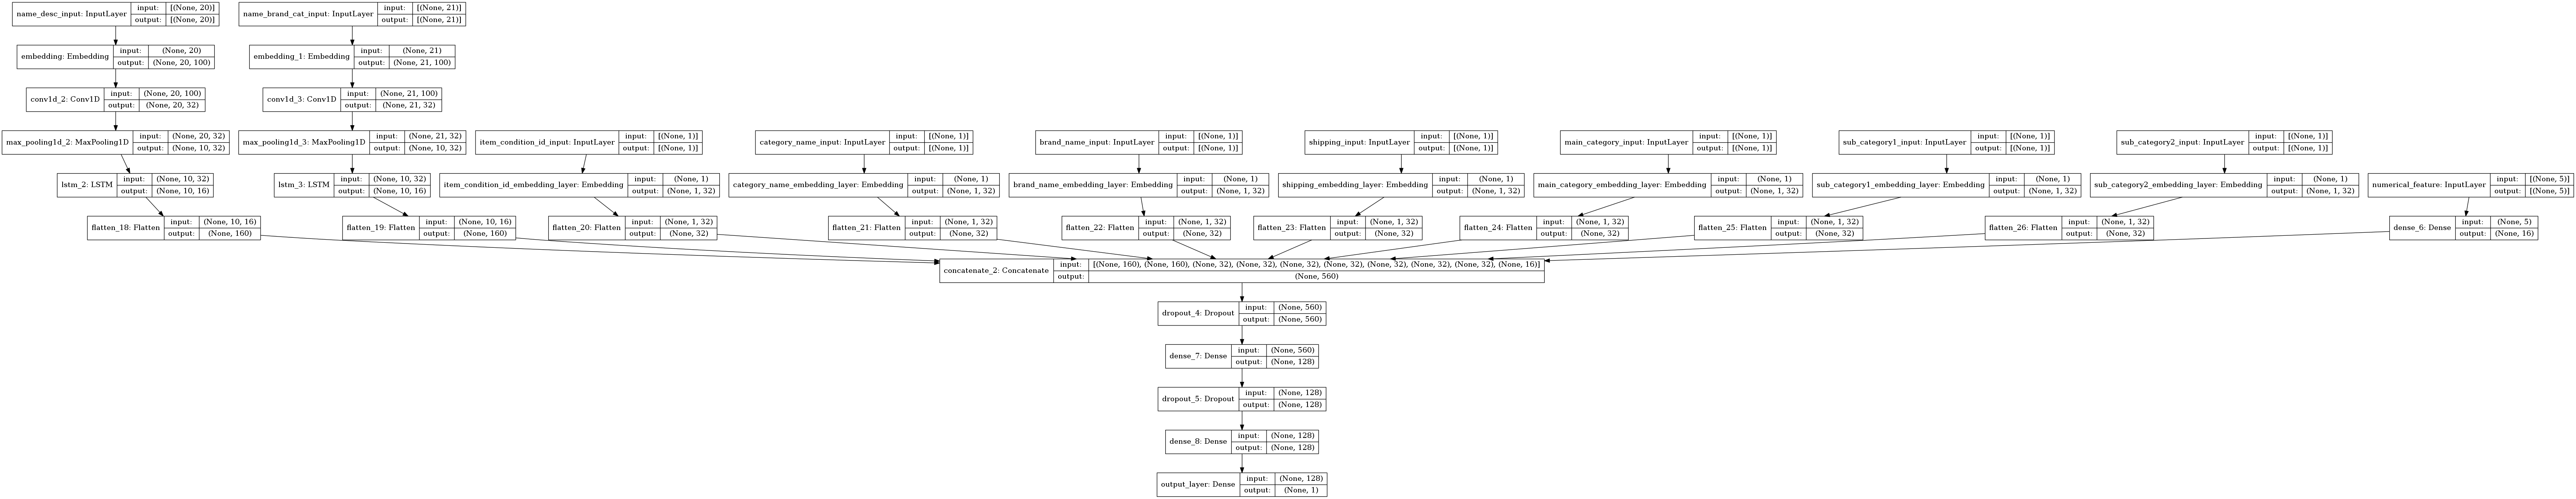

In [39]:
tf.keras.utils.plot_model(model_lstm_cnn, to_file='model_lstm_cnn.png', show_shapes=True, dpi=96)

In [40]:

model_path = "checkpoint/model_cnn.hdfs"
checking_point = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

lrscheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

model_lstm_cnn.compile(optimizer=Adam(0.0003), loss='mse', metrics=[RootMeanSquaredError()])

model_lstm_cnn_history = model_lstm_cnn.fit(x=X_train, y=y_train_scaled, batch_size=1024, epochs=50, verbose=True, validation_data=(X_test, y_test_scaled), 
                           callbacks=[checking_point])

Epoch 1/50
1303/1303 [==============================] - 61s 44ms/step - loss: 0.0194 - root_mean_squared_error: 0.1280 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1167

Epoch 00001: val_loss improved from inf to 0.01590, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 2/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0119 - root_mean_squared_error: 0.1010 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1107

Epoch 00002: val_loss improved from 0.01590 to 0.01348, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 3/50
1303/1303 [==============================] - 55s 43ms/step - loss: 0.0102 - root_mean_squared_error: 0.0964 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1020

Epoch 00003: val_loss improved from 0.01348 to 0.01101, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 4/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0092 - root_mean_squared_error: 0.0940 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1038

Epoch 00004: val_loss did not improve from 0.01101
Epoch 5/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0087 - root_mean_squared_error: 0.0924 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0997

Epoch 00005: val_loss improved from 0.01101 to 0.01004, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 6/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0084 - root_mean_squared_error: 0.0913 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968

Epoch 00006: val_loss improved from 0.01004 to 0.00939, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 7/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937

Epoch 00007: val_loss improved from 0.00939 to 0.00878, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 8/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0081 - root_mean_squared_error: 0.0897 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940

Epoch 00008: val_loss did not improve from 0.00878
Epoch 9/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948

Epoch 00009: val_loss did not improve from 0.00878
Epoch 10/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927

Epoch 00010: val_loss improved from 0.00878 to 0.00861, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 11/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930

Epoch 00011: val_loss did not improve from 0.00861
Epoch 12/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921

Epoch 00012: val_loss improved from 0.00861 to 0.00848, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 13/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936

Epoch 00013: val_loss did not improve from 0.00848
Epoch 14/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936

Epoch 00014: val_loss did not improve from 0.00848
Epoch 15/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918

Epoch 00015: val_loss improved from 0.00848 to 0.00843, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 16/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914

Epoch 00016: val_loss improved from 0.00843 to 0.00835, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 17/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940

Epoch 00017: val_loss did not improve from 0.00835
Epoch 18/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927

Epoch 00018: val_loss did not improve from 0.00835
Epoch 19/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926

Epoch 00019: val_loss did not improve from 0.00835
Epoch 20/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920

Epoch 00020: val_loss did not improve from 0.00835
Epoch 21/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.007

INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 26/50
1303/1303 [==============================] - 58s 44ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919

Epoch 00026: val_loss did not improve from 0.00825
Epoch 27/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909

Epoch 00027: val_loss did not improve from 0.00825
Epoch 28/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904

Epoch 00028: val_loss improved from 0.00825 to 0.00818, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 29/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924

Epoch 00029: val_loss did not improve from 0.00818
Epoch 30/50
1303/1303 [==============================] - 57s 43ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905

Epoch 00030: val_loss did not improve from 0.00818
Epoch 31/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0903

Epoch 00031: val_loss improved from 0.00818 to 0.00815, saving model to checkpoint/model_cnn.hdfs


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 32/50
1303/1303 [==============================] - 57s 43ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913

Epoch 00032: val_loss did not improve from 0.00815
Epoch 33/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927

Epoch 00033: val_loss did not improve from 0.00815
Epoch 34/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912

Epoch 00034: val_loss did not improve from 0.00815
Epoch 35/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904

Epoch 00035: val_loss did not improve from 0.00815
Epoch 36/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.007

INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 41/50
1303/1303 [==============================] - 57s 44ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914

Epoch 00041: val_loss did not improve from 0.00801
Epoch 42/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911

Epoch 00042: val_loss did not improve from 0.00801
Epoch 43/50
1303/1303 [==============================] - 57s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902

Epoch 00043: val_loss did not improve from 0.00801
Epoch 44/50
1303/1303 [==============================] - 57s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916

Epoch 00044: val_loss did not improve from 0.00801
Epoch 45/50
1303/1303 [==============================] - 57s 43ms/step - loss: 0.007

INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


INFO:tensorflow:Assets written to: checkpoint/model_cnn.hdfs/assets


Epoch 46/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899

Epoch 00046: val_loss did not improve from 0.00797
Epoch 47/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904

Epoch 00047: val_loss did not improve from 0.00797
Epoch 48/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894

Epoch 00048: val_loss did not improve from 0.00797
Epoch 49/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900

Epoch 00049: val_loss did not improve from 0.00797
Epoch 50/50
1303/1303 [==============================] - 56s 43ms/step - loss: 0.007

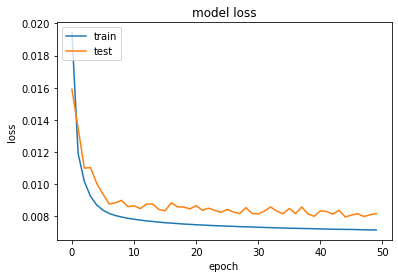

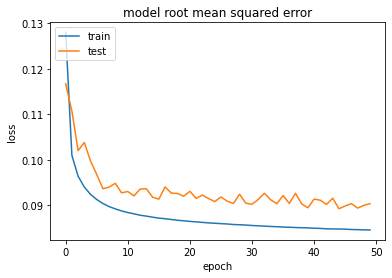

In [41]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_lstm_cnn_history.history['loss'])
plt.plot(model_lstm_cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_lstm_cnn_history.history['root_mean_squared_error'])
plt.plot(model_lstm_cnn_history.history['val_root_mean_squared_error'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission with lstm_cnn

In [49]:
# loading the model weights
path = "checkpoint/model_cnn.hdfs"
model_lstm_cnn = keras.models.load_model(path)

In [59]:
# predicting the prices
predicted_price = model_lstm_cnn.predict(test_input)

In [60]:
# loading the pickle file
price_scaler = pickle.load(open('Deep_learning/deep_learning_scaler/scaler_price.pkl','rb'))
# getting the original price
predicted_price = np.expm1(price_scaler.inverse_transform(predicted_price.reshape(-1,1)))

In [61]:
submission_df          = pd.DataFrame(test_df.test_id, columns=['test_id'])
submission_df['price'] = predicted_price

In [62]:
submission_df.to_csv('submission/deep_learning_submission_lstm_cnn.csv')

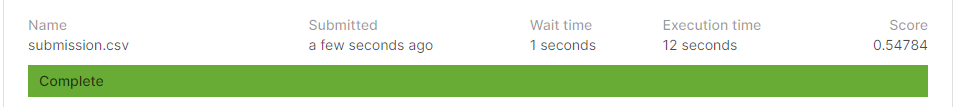

In [50]:
Image(filename='models_score/deep_lstm_cnn.png') 